In [1]:
from functools import partial
from jax import numpy as jnp, random, vmap
import matplotlib.pyplot as plt

import models
from filtering import filter_sweep

rk = random.PRNGKey(0)

n_players = 10
n_matches = 200

init_mean = 0.
init_sd = 1.
tau = 1.
s = 2.
epsilon = 1.

mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times = jnp.zeros(n_players)
init_player_skills = init_mean + init_sd * random.normal(init_skill_key, shape=(n_players,))


# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.trueskill.simulate(init_player_times,
                                                                      init_player_skills,
                                                                      match_times,
                                                                      match_indices_seq,
                                                                      tau,
                                                                      [s, epsilon],
                                                                      sim_key)
# Filter (with arbitrary parameters)
filter_sweep_data = partial(filter_sweep,
                            init_player_times=init_player_times,
                            match_times=match_times,
                            match_player_indices_seq=match_indices_seq,
                            match_results=sim_results,
                            random_key=filter_key)

elo_filter_out = filter_sweep_data(models.elo.filter,
                                   init_player_skills=init_player_skills,
                                   static_propagate_params=None, static_update_params=[1., 1.])

init_player_skills_and_var = jnp.vstack([init_player_skills, jnp.ones(n_players)]).T
glicko_filter_out = filter_sweep_data(models.glicko.filter,
                                      init_player_skills=init_player_skills_and_var,
                                      static_propagate_params=[1., 350 ** 2], static_update_params=None)

trueskill_filter_out = filter_sweep_data(models.trueskill.filter,
                                         init_player_skills=init_player_skills_and_var,
                                         static_propagate_params=tau, static_update_params=[s, epsilon])

n_particles = 100
init_player_skills_particles = init_player_skills.reshape(n_players, 1) \
                               + init_sd * random.normal(init_particle_key, shape=(n_players, n_particles))
lsmc_filter_out = filter_sweep_data(models.lsmc.filter,
                                    init_player_skills=init_player_skills_particles,
                                    static_propagate_params=tau, static_update_params=[s, epsilon])

initial_distribution_skills = jnp.zeros((10))
initial_distribution_skills = initial_distribution_skills.at[0].set(0.8)
initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)

_, initial_distribution_skills_player = models.discreteskill.initiator(n_players, initial_distribution_skills, rk)

discrete_filter_out  = filter_sweep_data(models.discreteskill.filter,
                                         init_player_skills=initial_distribution_skills_player,
                                         static_propagate_params=tau, static_update_params=[s, epsilon])

# Plot results
bin_width = 0.2
inds = jnp.arange(20)#n_matches)
alph = 0.5


def plot_predictions(ax, predictions, barpos):
    ax.bar(inds + barpos * bin_width, predictions[:, 2], bottom=1 - predictions[:, 2], width=bin_width * 0.8,
           color='purple', alpha=alph)  # p2 wins
    ax.bar(inds + barpos * bin_width, predictions[:, 0], bottom=predictions[:, 1], width=bin_width * 0.8, color='blue',
           alpha=alph)  # draw
    ax.bar(inds + barpos * bin_width, predictions[:, 1], bin_width * 0.8, color='green', alpha=alph)  # p1 wins



: 

: 

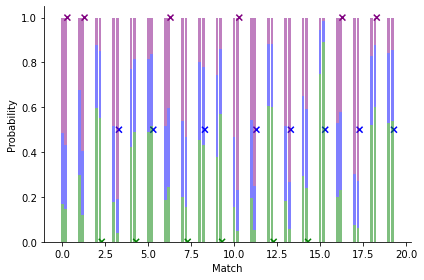

In [ ]:
fig, ax = plt.subplots()
plot_predictions(ax, discrete_filter_out[-1][-20:,:], 0)
# plot_predictions(ax, glicko_filter_out[-1], 1)
# plot_predictions(ax, trueskill_filter_out[-1], 2)
plot_predictions(ax, lsmc_filter_out[-1][-20:,:], 1)
# plot_predictions(ax, discrete_filter_out[-1], 4)

res_cols = [['blue', 'green', 'purple'][r] for r in sim_results[-20:]]
res_to_probpos = {0: 0.5, 1: 0, 2: 1}
res_probs = [res_to_probpos[int(r)] for r in sim_results[-20:]]
ax.scatter(inds + bin_width * 1.5, res_probs, c=res_cols, marker='x')
ax.set_xlabel('Match')
ax.set_ylabel('Probability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

In [1]:
from jax import numpy as jnp, random, vmap
import matplotlib.pyplot as plt

import models
from filtering import filter_sweep
from smoothing import smoother_sweep, times_and_skills_by_match_to_by_player

rk = random.PRNGKey(0)

n_players = 10
n_matches = 50

init_mean = 0.
init_var = 3.
tau = 1.
s = 1.
epsilon = 10.

mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

# match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
match_times = jnp.arange(1, n_matches + 1)
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times = jnp.zeros(n_players)
init_player_skills = init_mean + jnp.sqrt(init_var) * random.normal(init_skill_key, shape=(n_players,))

# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.trueskill.simulate(init_player_times,
                                                                      init_player_skills,
                                                                      match_times,
                                                                      match_indices_seq,
                                                                      tau,
                                                                      [s, epsilon],
                                                                      sim_key)

print(f'Prop draws = {(sim_results == 0).mean() * 100:.2f}%')


true_times_by_player, true_skills_by_player = times_and_skills_by_match_to_by_player(init_player_times,
                                                                                     init_player_skills,
                                                                                     match_times,
                                                                                     match_indices_seq,
                                                                                     sim_skills_p1,
                                                                                     sim_skills_p2)

em_init_mean_and_var = jnp.array([init_mean, init_var])
em_init_tau = tau
em_init_s_and_epsilon = jnp.array([s, epsilon])

# TrueSkill (EP) filter and smooth
trueskill_init_times, trueskill_init_skills = models.trueskill.initiator(n_players, em_init_mean_and_var)
trueskill_filter_out = filter_sweep(models.trueskill.filter,
                                    trueskill_init_times, trueskill_init_skills,
                                    match_times, match_indices_seq, sim_results, em_init_tau, em_init_s_and_epsilon)

trueskill_times_by_player, trueskill_filter_skills_by_player = times_and_skills_by_match_to_by_player(
    trueskill_init_times,
    trueskill_init_skills,
    match_times,
    match_indices_seq,
    trueskill_filter_out[0],
    trueskill_filter_out[1])
trueskill_smoother_skills_and_extras = [smoother_sweep(models.trueskill.smoother,
                                                       trueskill_times_by_player[p_ind],
                                                       trueskill_filter_skills_by_player[p_ind],
                                                       em_init_tau,
                                                       None) for p_ind in range(len(trueskill_times_by_player))]

# TrueSkill (SMC) filter and smooth
models.lsmc.n_particles = 1000
lsmc_init_times, lsmc_init_skills = models.lsmc.initiator(n_players, em_init_mean_and_var, rk)
lsmc_filter_out = filter_sweep(models.lsmc.filter,
                               lsmc_init_times, lsmc_init_skills,
                               match_times, match_indices_seq, sim_results, em_init_tau, em_init_s_and_epsilon)

lsmc_times_by_player, lsmc_filter_skills_by_player = times_and_skills_by_match_to_by_player(lsmc_init_times,
                                                                                            lsmc_init_skills,
                                                                                            match_times,
                                                                                            match_indices_seq,
                                                                                            lsmc_filter_out[0],
                                                                                            lsmc_filter_out[1])
lsmc_smoother_skills_and_extras = [smoother_sweep(models.lsmc.smoother,
                                                  lsmc_times_by_player[p_ind],
                                                  lsmc_filter_skills_by_player[p_ind],
                                                  em_init_tau,
                                                  None) for p_ind in range(len(lsmc_times_by_player))]

Prop draws = 70.00%


In [2]:
# Discrete (EP) filter and smooth
initial_distribution_skills = jnp.zeros((10))+0.05
initial_distribution_skills = initial_distribution_skills.at[0].set(0.4)
initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)
discrete_init_times, discrete_init_skills = models.discreteskill.initiator(n_players, initial_distribution_skills, rk)

discrete_filter_out = filter_sweep(models.discreteskill.filter,
                                    discrete_init_times, discrete_init_skills,
                                    match_times, match_indices_seq, sim_results, em_init_tau, em_init_s_and_epsilon)

discrete_times_by_player, discrete_filter_skills_by_player = times_and_skills_by_match_to_by_player(
    discrete_init_times,
    discrete_init_skills,
    match_times,
    match_indices_seq,
    discrete_filter_out[0],
    discrete_filter_out[1])

In [6]:
discrete_filter_skills_by_player[0].shape

(10, 10)

In [3]:
discrete_smoother_skills_and_extras = [smoother_sweep(models.discreteskill.smoother,
                                                       discrete_times_by_player[p_ind],
                                                       discrete_filter_skills_by_player[p_ind],
                                                       em_init_tau,
                                                       None) for p_ind in range(len(discrete_times_by_player))]

Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>


In [20]:
trueskill_smoother_skills_and_extras[i][1]

DeviceArray([ 12.075465,  85.53594 , 101.52056 ,  98.497536,  89.45616 ,
              83.192566,  84.360695,  89.76003 ,  76.033585,  65.38106 ,
              62.616695], dtype=float32)

In [21]:
discrete_smoother_skills_and_extras[0][1].shape

(9, 10, 10)

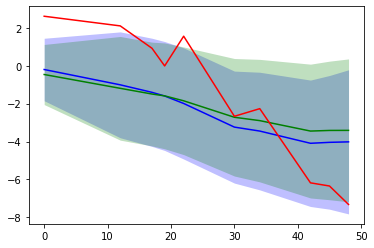

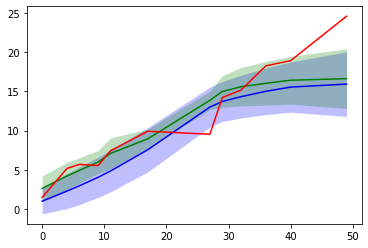

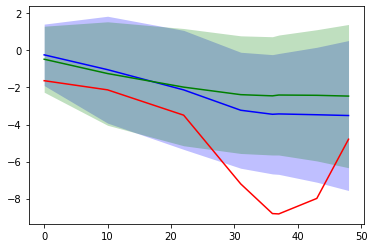

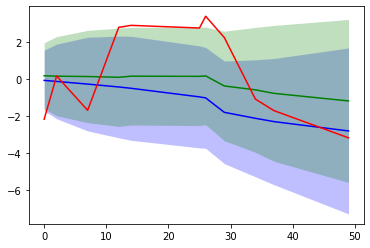

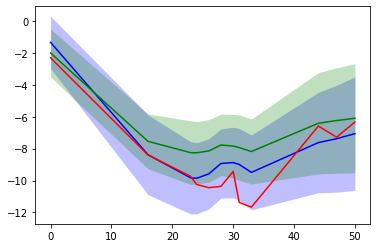

In [6]:
for i in range(min(n_players, 5)):
    fig, ax = plt.subplots()
    ts_mn = trueskill_smoother_skills_and_extras[i][0][:, 0]
    ts_sd = jnp.sqrt(trueskill_smoother_skills_and_extras[i][0][:, 1])
    ax.fill_between(trueskill_times_by_player[i], ts_mn - ts_sd, ts_mn + ts_sd, color='blue', alpha=0.25, linewidth=0)
    ax.plot(trueskill_times_by_player[i], ts_mn, color='blue')

    lsmc_mn = lsmc_smoother_skills_and_extras[i][0].mean(1)
    lsmc_std = jnp.std(lsmc_smoother_skills_and_extras[i][0], axis=1)
    ax.fill_between(lsmc_times_by_player[i], lsmc_mn - lsmc_std, lsmc_mn + lsmc_std,
                    color='green', alpha=0.25, linewidth=0)
    ax.plot(lsmc_times_by_player[i], lsmc_mn, color='green')

    ax.plot(true_times_by_player[i], true_skills_by_player[i], color='red')

In [ ]:
a